# Mice TBI Segmentation Thesis
## Skullstripping segmentation
Author: Marcello De Salvo <br>

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Loss Function](#loss)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [1]:
import os
import PIL
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize as resz
from PIL import Image, ImageOps
import time


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import visualkeras
#!pip install segmentation-models-3D==1.0.5
#import segmentation_models_3D as sm 
import evaluation.inference
importlib.reload(evaluation.inference)
from evaluation.inference import SkullFVE

import seaborn as sns
sns.set_theme(style="whitegrid")

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


KeyboardInterrupt: 

# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
**Skullstripping of mice brains**

Each pixel in the image has to be assigned one of the following labels: <br>
- 0 - Background
- 1 - Brain

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T2 (Rare)**
2. **FLASH**
3. **DTI**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [ ]:
# PRE PROCESSING
import time
# All labels [0,1,2,3,4,5,10,11,12,13,14,15,16]
# Labels currently used [0,1,12,13,14]
config ={
    'k': 5,
    'dataset_path': '..\dataset_skullstripping',
    'input_shape': (64, 64, 64),
    'target_resolution': (0.1,0.1,0.1),
    'num_classes': 1,
    'in_channels': 1,
    'batch_size': 8,
    'epochs': 100,
    'lr': 1e-3,
    'model_name': "k_fold_skull" + "_ep" + str(250) + time.strftime("_%d-%m-%Y_%H-%M"),
    'augment':  True,
    'data_multiplier': 5,
}

# 6. Loss function <a class='anchor' id='loss'></a> [↑](#top)

**Dice coefficient** <br>
The Dice coefficient (also known as the Sørensen-Dice coefficient) is used to measure the similarity or overlap between two sets. In this context, it's used to measure the similarity between the ground truth binary mask (y_true) and the predicted binary mask (y_pred) for a specific class. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. <br> 
The Dice coefficient was originally developed for binary data, and can be calculated as:

![dice loss](https://miro.medium.com/v2/resize:fit:544/1*5eHgttXxEMukIJdqr2_ZNw.png)

In our case this translates into:
- Intersection: This is the sum of the element-wise multiplication of the ground truth mask and the predicted mask.<br>
- X or Area of y_true: This is the sum of all non-zero values in the ground truth mask, representing the total number of pixels that belong to the class in the ground truth.
- Y or Area of y_pred: This is the sum of all non-zero values in the predicted mask, representing the total number of pixels that the model predicted as belonging to the class.

### Custom Losses
The term "smooth" is typically a small positive value that is added to the numerator and denominator of the Dice coefficient formula. Its purpose is to prevent division by zero.<br>
I'll use the **Soft Dice Loss** as explained here: https://www.jeremyjordan.me/semantic-segmentation/

In [ ]:
import evaluation.metrics
importlib.reload(evaluation.metrics)
from evaluation.metrics import *

# Define the metrics list
metrics = ['accuracy', precision, sensitivity, specificity, dice_coefficient, iou_coefficient, volume_similarity_coefficient] 

# Create a dictionary to store the results
metrics_dic = {metric.__name__ if hasattr(metric, '__name__') else 'accuracy': [] for metric in metrics}

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import load_data, getDirectories

# Use the function to obtain a list of study IDs from the list of directories
modalities_directories = {
    'FLASH': 'Anat',
    'RARE': 'Anat',
    'DTI': 'DTI',
}


train_and_test_ids = []

for modality in modalities_directories:
    print(f"Processing {modality}...")
    modality_path = os.path.join(config['dataset_path'], modality)
    # extract the ids from the subfolders
    ids = getDirectories(modality_path)
    # make a list of tuples (id, modality, folder)
    ids = [(id, modality, modalities_directories[modality]) for id in ids]
    train_and_test_ids.append(ids)

# flatten the list
train_and_test_ids = [item for sublist in train_and_test_ids for item in sublist]
print('Size of the dataset: ', len(train_and_test_ids))

Processing FLASH...
Processing RARE...
Processing DTI...
Size of the dataset:  134


In [ ]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping
import preprocessing.augmentation
importlib.reload(preprocessing.augmentation)
from preprocessing.augmentation import Augmentator3D, GaussianBlur, Noise, RandomAffine
import preprocessing.generator
importlib.reload(preprocessing.generator)
from preprocessing.generator import DataSkullStrip
import SimpleITK as sitk

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

# Create an instance of the MRIProcessor class
processor = Preprocessor([
    CorrectX10(verbose=False),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Reorient(ref_img),
    Normalize(),
    RandomCropping(config['input_shape'], mode='center', std=30)
])


# Create an instance of the Augmentator3D class
augmentator = Augmentator3D(    RandomAffine(rotation_range=[-5,5], scale_range=[0.95,1.05], probability=0.3, interpolation=sitk.sitkNearestNeighbor),
                                GaussianBlur([0,0.6], 0.3),
                                Noise([0,0.05], 0.3), )

Augmentator configuration:
- RandomAffine probability: 0.3
- GaussianBlur probability: 0.3
- Noise probability: 0.3




# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [ ]:
import models.layers3D
importlib.reload(models.layers3D)
from models.layers3D import *
import models.models
importlib.reload(models.models)
from models.models import *

# Example usage:
filters = [32, 64, 96, 128] # Filters for the encoder
#model = ds_unet(config['input_shape'], config['num_classes'], filters)
model = ResidualUnet3D(config['input_shape'], config['in_channels'], config['num_classes'], filters, residual=False, attention=False, transpose=False, dropout=0.2, activation='sigmoid')
loss = dice_bce_loss(alpha=0.3)

In [ ]:
# Print summary of the model giving the input shape to function
model.summary()

# save the model summary to a file
# create a folder for the model
if not os.path.exists('../results/'+config['model_name']):
    os.makedirs('../results/'+config['model_name'])
with open('../results/'+config['model_name']+'/modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64,   128        ['conv3d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
import datetime

def create_callbacks(fold):
    csv_logger = CSVLogger('../results/'+config['model_name']+'/training.log', separator=',', append=False)
    log_dir = "../results/"+config['model_name']+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_path = "../results/"+config['model_name']+"/checkpoint/"
    checkpoint_path = os.path.join(checkpoint_path, f"fold_{fold}")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
            csv_logger
        ]
    return callbacks, checkpoint_path

## K-Folds (data aug)

In [ ]:
from sklearn.model_selection import KFold

# define a list to store the training history for each fold
history_k = []
test_results = []

# split the training set into k folds
kfold = KFold(n_splits=config['k'], shuffle=True, random_state=42)
all_fold_metrics = []

# make a loop extracting the dictionaries for train and validation for each fold
for fold, (train_ids_k, val_ids_k) in enumerate(kfold.split(train_and_test_ids)):
    # convert ids to dictionaries
    train_ids_k = [train_and_test_ids[i] for i in train_ids_k]
    val_ids_k = [train_and_test_ids[i] for i in val_ids_k]

    # concatenate the train and validation ids to themselves to increase the size of the dataset and the patches to train on
    train_ids_k = train_ids_k
    val_ids_k = val_ids_k * config['data_multiplier']

    steps = len(train_ids_k) // config['batch_size']
    val_steps = len(val_ids_k) // config['batch_size']
    
    print(f'FOLD {fold}')
    print('--------------------------------')
    print(f'Training on {len(train_ids_k)} examples')
    print("Train IDs: ",  np.unique(train_ids_k))
    print(f'\nValidating on {len(val_ids_k)} examples')
    print("Validation IDs: ", np.unique(val_ids_k))
    print('--------------------------------')

    # Make directories for the fold
    if not os.path.exists('../results/'+config['model_name']+'/fold_'+str(fold)):
        os.makedirs('../results/'+config['model_name']+'/fold_'+str(fold))
    
    # Save in the same file the unique ids for train and validation
    with open('../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'train_val_ids_fold_'+str(fold)+'.txt', 'w') as f:
        for item in np.unique(train_ids_k):
            f.write("%s\n" % item)
        for item in np.unique(val_ids_k):
            f.write("%s\n" % item)

    # Create train and validation generators    
    train_gen = DataSkullStrip(train_ids_k, batch_size=config['batch_size'], augment=config['augment'], config=config, augmentator=augmentator, preprocessor=processor)
    val_gen = DataSkullStrip(val_ids_k, batch_size=config['batch_size'], config=config, preprocessor=processor)

    # Create callbacks
    callbacks, checkpoint_path = create_callbacks(fold)
    
    #model = ds_unet(input_shape=config['input_shape'], in_channels=config['in_channels'], num_classes=config['num_classes'], filters=filters)
    model = ResidualUnet3D(config['input_shape'], config['in_channels'], config['num_classes'], filters, residual=False, attention=False, transpose=False, dropout=0.2, activation='sigmoid')
    
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Nadam(learning_rate=config['lr']), metrics = metrics)
    k_history = model.fit(train_gen, validation_data=val_gen, epochs=config['epochs'], steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

    # append
    history_k.append(k_history.history)

    # Load weights from the best model
    model.load_weights(checkpoint_path).expect_partial()
    # save the model
    model.save('../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'/model_fold_'+str(fold)+'.h5')

    # plot loss and val loss
    plt.figure(figsize=(15, 5))
    plt.plot(k_history.history['loss'])
    plt.plot(k_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('log-loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'/loss_fold_'+str(fold)+'.png')
    plt.show()

    # plot metrics
    n_metrics = len(metrics)
    
    # Create a figure with a subplot for each metric in a grid
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    sns.set_style("whitegrid")
    axs = axs.ravel()

    # Start from index 1 to skip the first metric (assumed to be loss)
    for i, metric in enumerate(list(metrics_dic.keys())):
        # If starts with val_ skip
        if metric.startswith('val_'):
            continue
        axs[i].plot(k_history.history[metric], label='Train')
        axs[i].plot(k_history.history['val_' + metric], label='Validation')
        axs[i].set_title(metric)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric)
        axs[i].legend()

    # save in a excel file
    df = pd.DataFrame(k_history.history)
    df.to_excel('../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'/history_fold_'+str(fold)+'.xlsx', index=False)
    plt.tight_layout()
    plt.savefig('../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'/metrics_fold_'+str(fold)+'.png')
    plt.show()

    # Full volume evaluation
    inferenceProcessor = Preprocessor([
        CorrectX10(verbose=True),
        Resample(target_resolution=config['target_resolution'], interpolation=0),
        Reorient(ref_img),
        Normalize(),
    ])
    full_volume_eval = SkullFVE(model, val_ids_k, config, modalities_directories.keys(), strides=[48,64], preprocessor=inferenceProcessor, path='../results/'+config['model_name']+'/fold_'+str(fold)+'/')
    fold_dataframe = full_volume_eval.evaluate()
    all_fold_metrics.append(fold_dataframe)


FOLD 0
--------------------------------
Training on 107 examples
Train IDs:  ['Anat' 'DTI' 'FLASH' 'RARE' 'TBI_MC_fp_22_126_5M' 'TBI_MC_fp_22_127_5M'
 'TBI_MC_fp_22_127_5W' 'TBI_MC_fp_22_128_5M' 'TBI_MC_fp_22_129_5M'
 'TBI_MC_fp_22_130_5M' 'TBI_MC_fp_22_130_5W' 'TBI_MC_fp_22_132_5M'
 'TBI_MC_fp_22_132_5W' 'TBI_MC_fp_22_134_5M' 'TBI_MC_fp_22_136_5M'
 'TBI_MC_fp_22_137_5M' 'TBI_MC_fp_22_138_5M' 'TBI_MC_fp_22_146_5M'
 'TBI_MC_fp_22_149_5M' 'TBI_MC_fp_22_150_5M' 'TBI_MC_fp_22_151_5M'
 'TBI_MC_fp_22_153' 'TBI_MC_fp_22_153_5M' 'TBI_MC_fp_22_154'
 'TBI_MC_fp_22_154_5M' 'TBI_MC_fp_22_156' 'TBI_MC_fp_22_156_5M'
 'TBI_MC_fp_22_157' 'TBI_MC_fp_22_160_5W' 'TBI_MC_fp_22_162_5W'
 'TBI_MC_fp_22_163_5W' 'TBI_MC_fp_22_164_5W' 'TBI_MC_fp_22_166'
 'TBI_MC_fp_22_166_5W' 'TBI_MC_fp_22_167' 'TBI_MC_fp_22_167_5W'
 'TBI_MC_fp_22_168' 'TBI_MC_fp_22_168_5W' 'TBI_MC_fp_22_169'
 'TBI_MC_fp_22_169_5M' 'TBI_MC_fp_22_169_5W' 'TBI_MC_fp_22_170'
 'TBI_MC_fp_22_170_5W' 'TBI_MC_fp_22_182' 'TBI_MC_fp_22_183'
 'TBI_MC_fp_

In [ ]:
# print average metrics
print("Average metrics")

# define a list of lists to store the best values of each metric in validation
best_metrics_val = []

for i in range(config['k']):
    print(f"|- Fold {i} -----------------")
    best_metric_k = {}

    best_epoch_k = np.argmin(history_k[i]['val_loss'])
    # take last value of each metric in validation
    best_metric_k['val_loss'] = history_k[i]['val_loss'][best_epoch_k]
    for key in metrics_dic.keys():
        best_metric_k['val_'+key] = history_k[i]['val_'+key][best_epoch_k]
        print(f"|- {'val_'+key}: {history_k[i]['val_'+key][best_epoch_k]}")

    best_metrics_val.append(best_metric_k)

Average metrics
|- Fold 0 -----------------
|- val_accuracy: 0.9242411851882935
|- val_precision: 0.8790864944458008
|- val_sensitivity: 0.9752188324928284
|- val_specificity: 0.8756421804428101
|- val_dice_coefficient: 0.9244199395179749
|- val_iou_coefficient: 0.8599483966827393
|- val_volume_similarity_coefficient: 0.9478980302810669
|- Fold 1 -----------------
|- val_accuracy: 0.7032673358917236
|- val_precision: 0.9773524403572083
|- val_sensitivity: 0.40967583656311035
|- val_specificity: 0.9903180599212646
|- val_dice_coefficient: 0.5770063400268555
|- val_iou_coefficient: 0.40584447979927063
|- val_volume_similarity_coefficient: 0.5903398394584656
|- Fold 2 -----------------
|- val_accuracy: 0.907916784286499
|- val_precision: 0.8652584552764893
|- val_sensitivity: 0.9687179923057556
|- val_specificity: 0.8407162427902222
|- val_dice_coefficient: 0.9137960076332092
|- val_iou_coefficient: 0.8417161703109741
|- val_volume_similarity_coefficient: 0.9434150457382202
|- Fold 3 ----

In [ ]:
# compute average for each fold
average_metrics = {}

average_metrics['val_loss'] = np.mean([h['val_loss'] for h in best_metrics_val])
for key in metrics_dic.keys():
    average_metrics['val_'+key] = np.mean([h['val_'+key] for h in best_metrics_val])

# print average metrics
print("Average metrics")
for key in average_metrics.keys():
    print(f"|- AVG VAL - {key}: {average_metrics[key]}")

Average metrics
|- AVG VAL - val_loss: 0.1916488766670227
|- AVG VAL - val_accuracy: 0.8630146384239197
|- AVG VAL - val_precision: 0.9315665483474731
|- AVG VAL - val_sensitivity: 0.7857503414154052
|- AVG VAL - val_specificity: 0.9322118043899537
|- AVG VAL - val_dice_coefficient: 0.8273856163024902
|- AVG VAL - val_iou_coefficient: 0.7287471950054168
|- AVG VAL - val_volume_similarity_coefficient: 0.8518333196640014


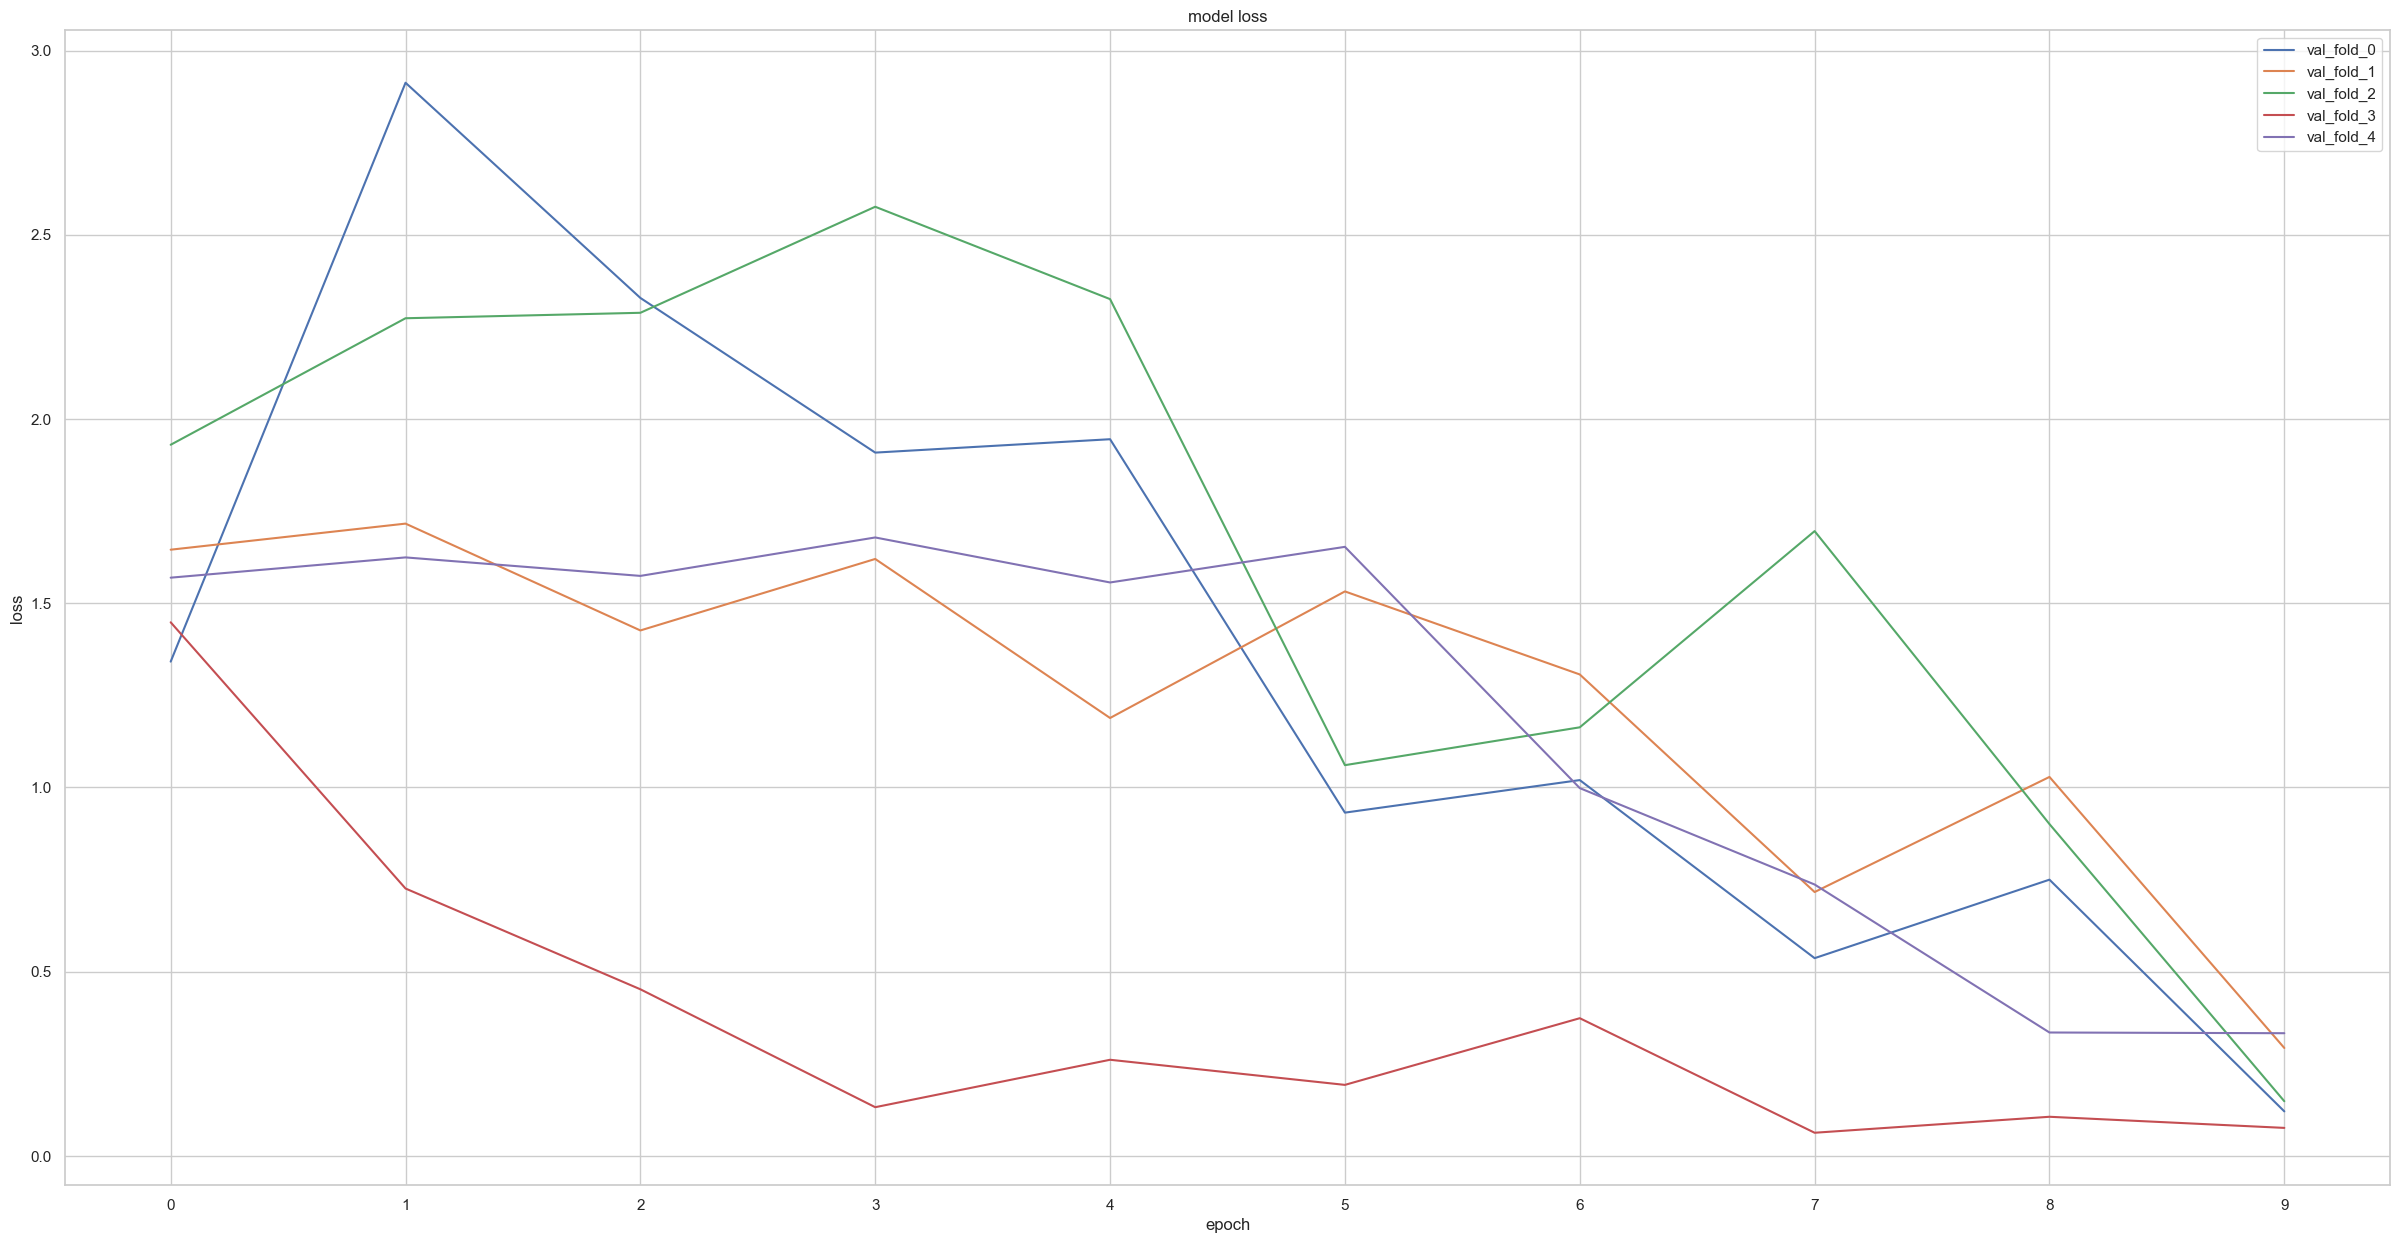

In [ ]:
plt.figure(figsize=(30, 15))
for i in range(config['k']):
    plt.plot(np.arange(len(history_k[i]['val_loss'])),history_k[i]['val_loss'], label='val_fold_'+str(i))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, len(history_k[0]['val_loss']), step=1), labels=np.arange(0, len(history_k[0]['val_loss']), step=1))
plt.legend()

plt.savefig('../results/'+config['model_name']+'/log_val_loss.png')
plt.show()

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\1906757242.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\1906757242.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



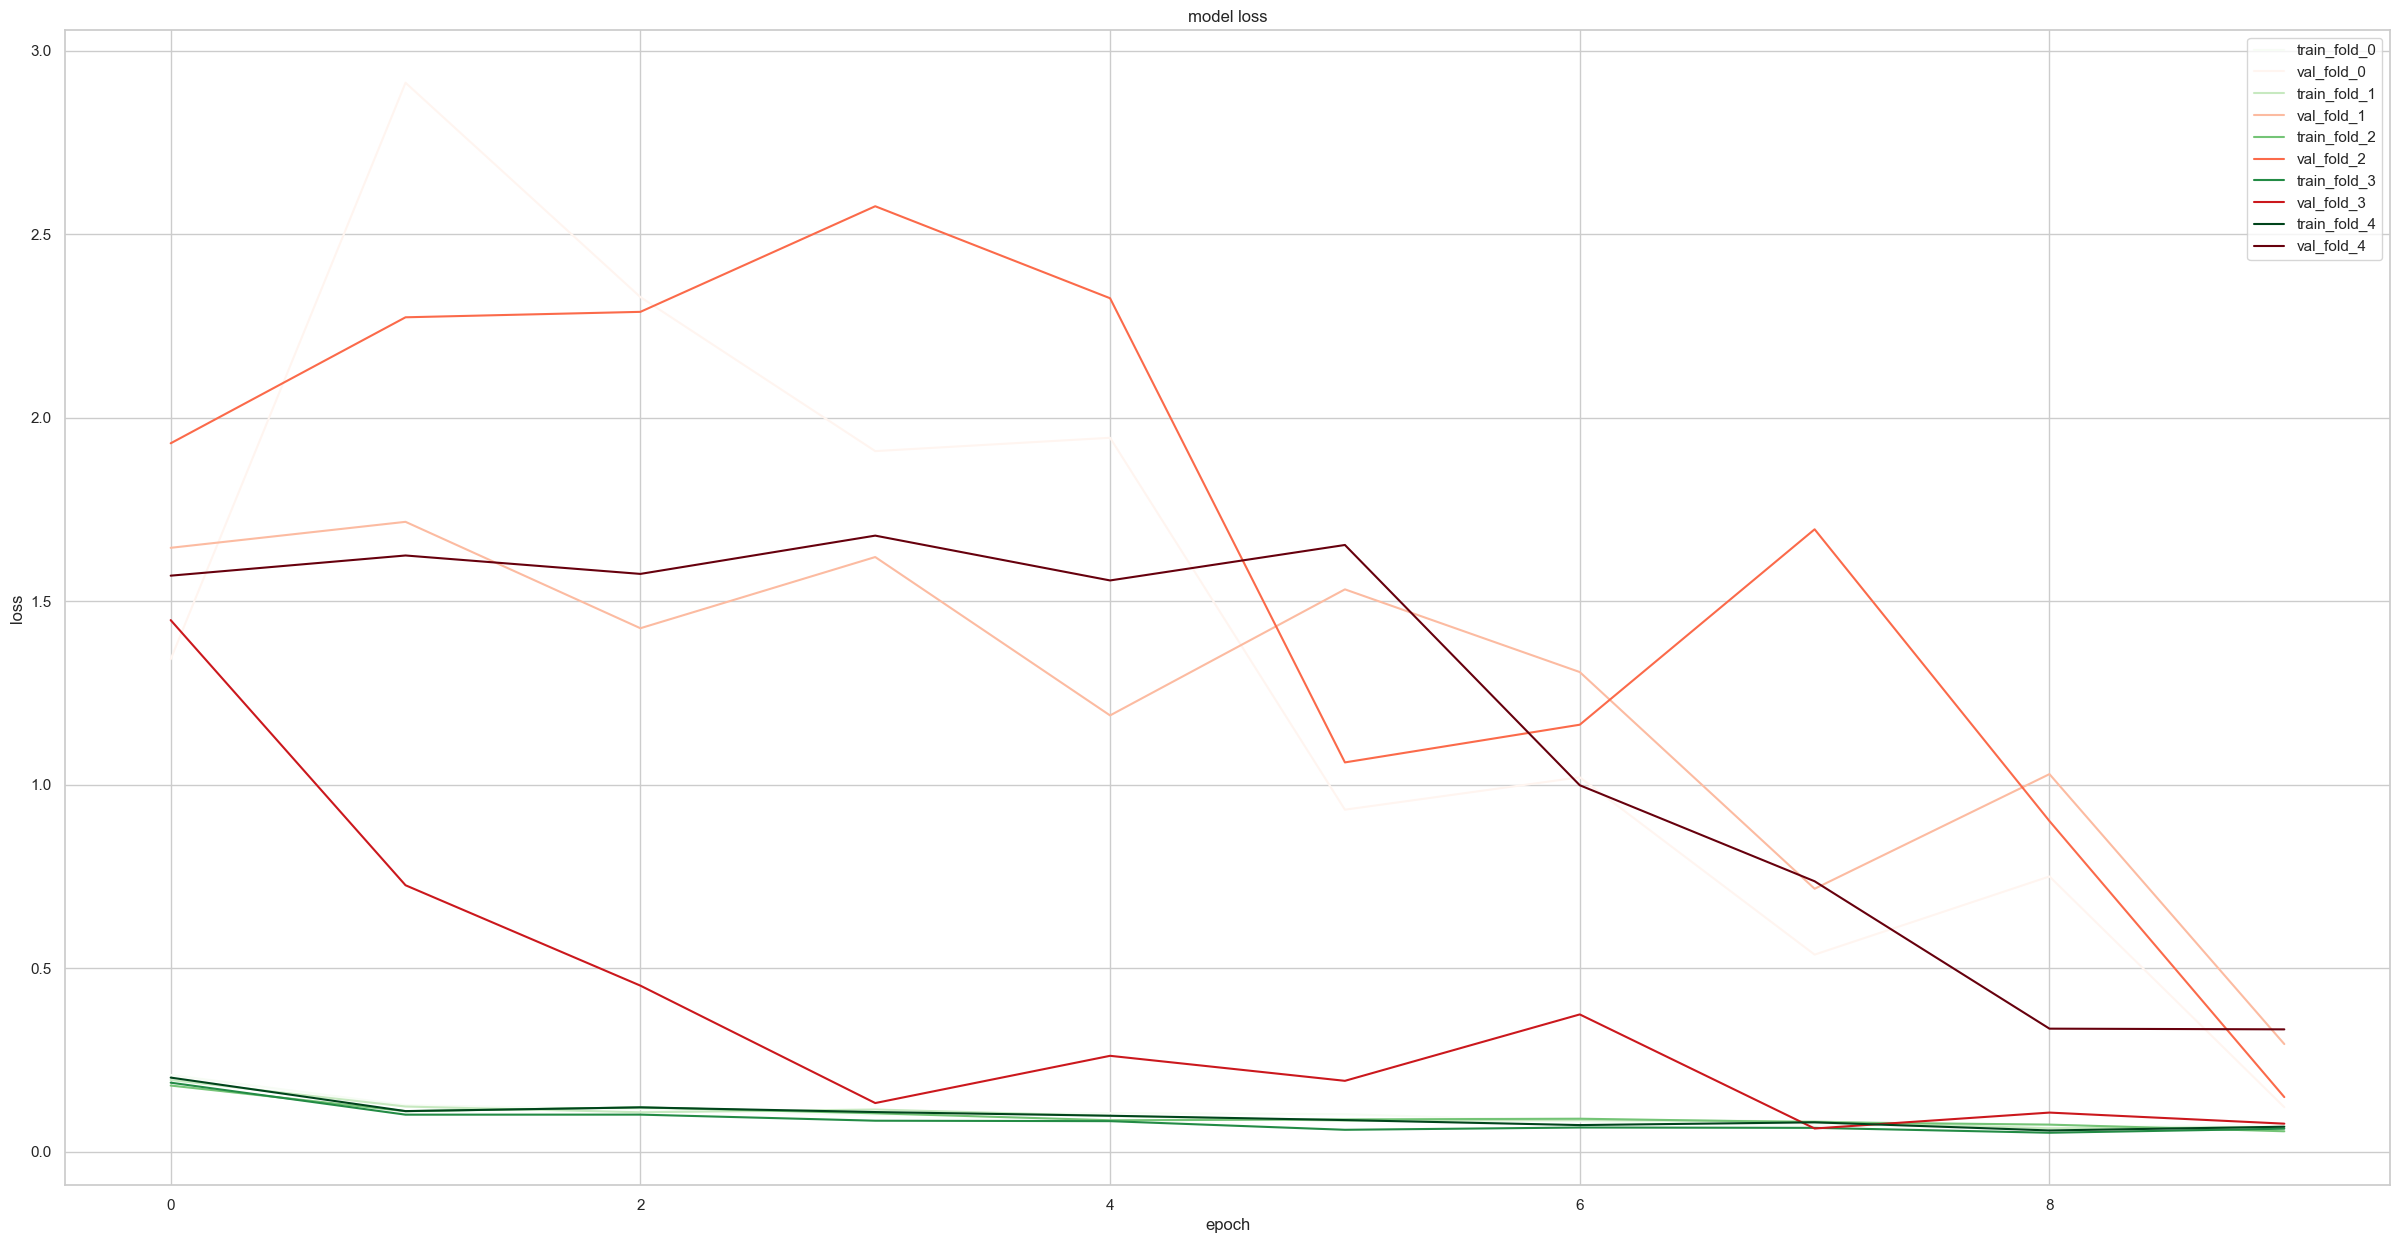

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))
sns.set_style("whitegrid")
train_colors = plt.cm.get_cmap('Greens', config['k'])  # Green palette for train
val_colors = plt.cm.get_cmap('Reds', config['k'])     # Reds palette for val

for i in range(config['k']):
    plt.plot(np.arange(len(history_k[i]['loss'])), history_k[i]['loss'], label='train_fold_'+str(i), color=train_colors(i))
    plt.plot(np.arange(len(history_k[i]['val_loss'])),history_k[i]['val_loss'], label='val_fold_'+str(i), color=val_colors(i))

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('../results/'+config['model_name']+'/log_train_val_loss.png')
plt.show()

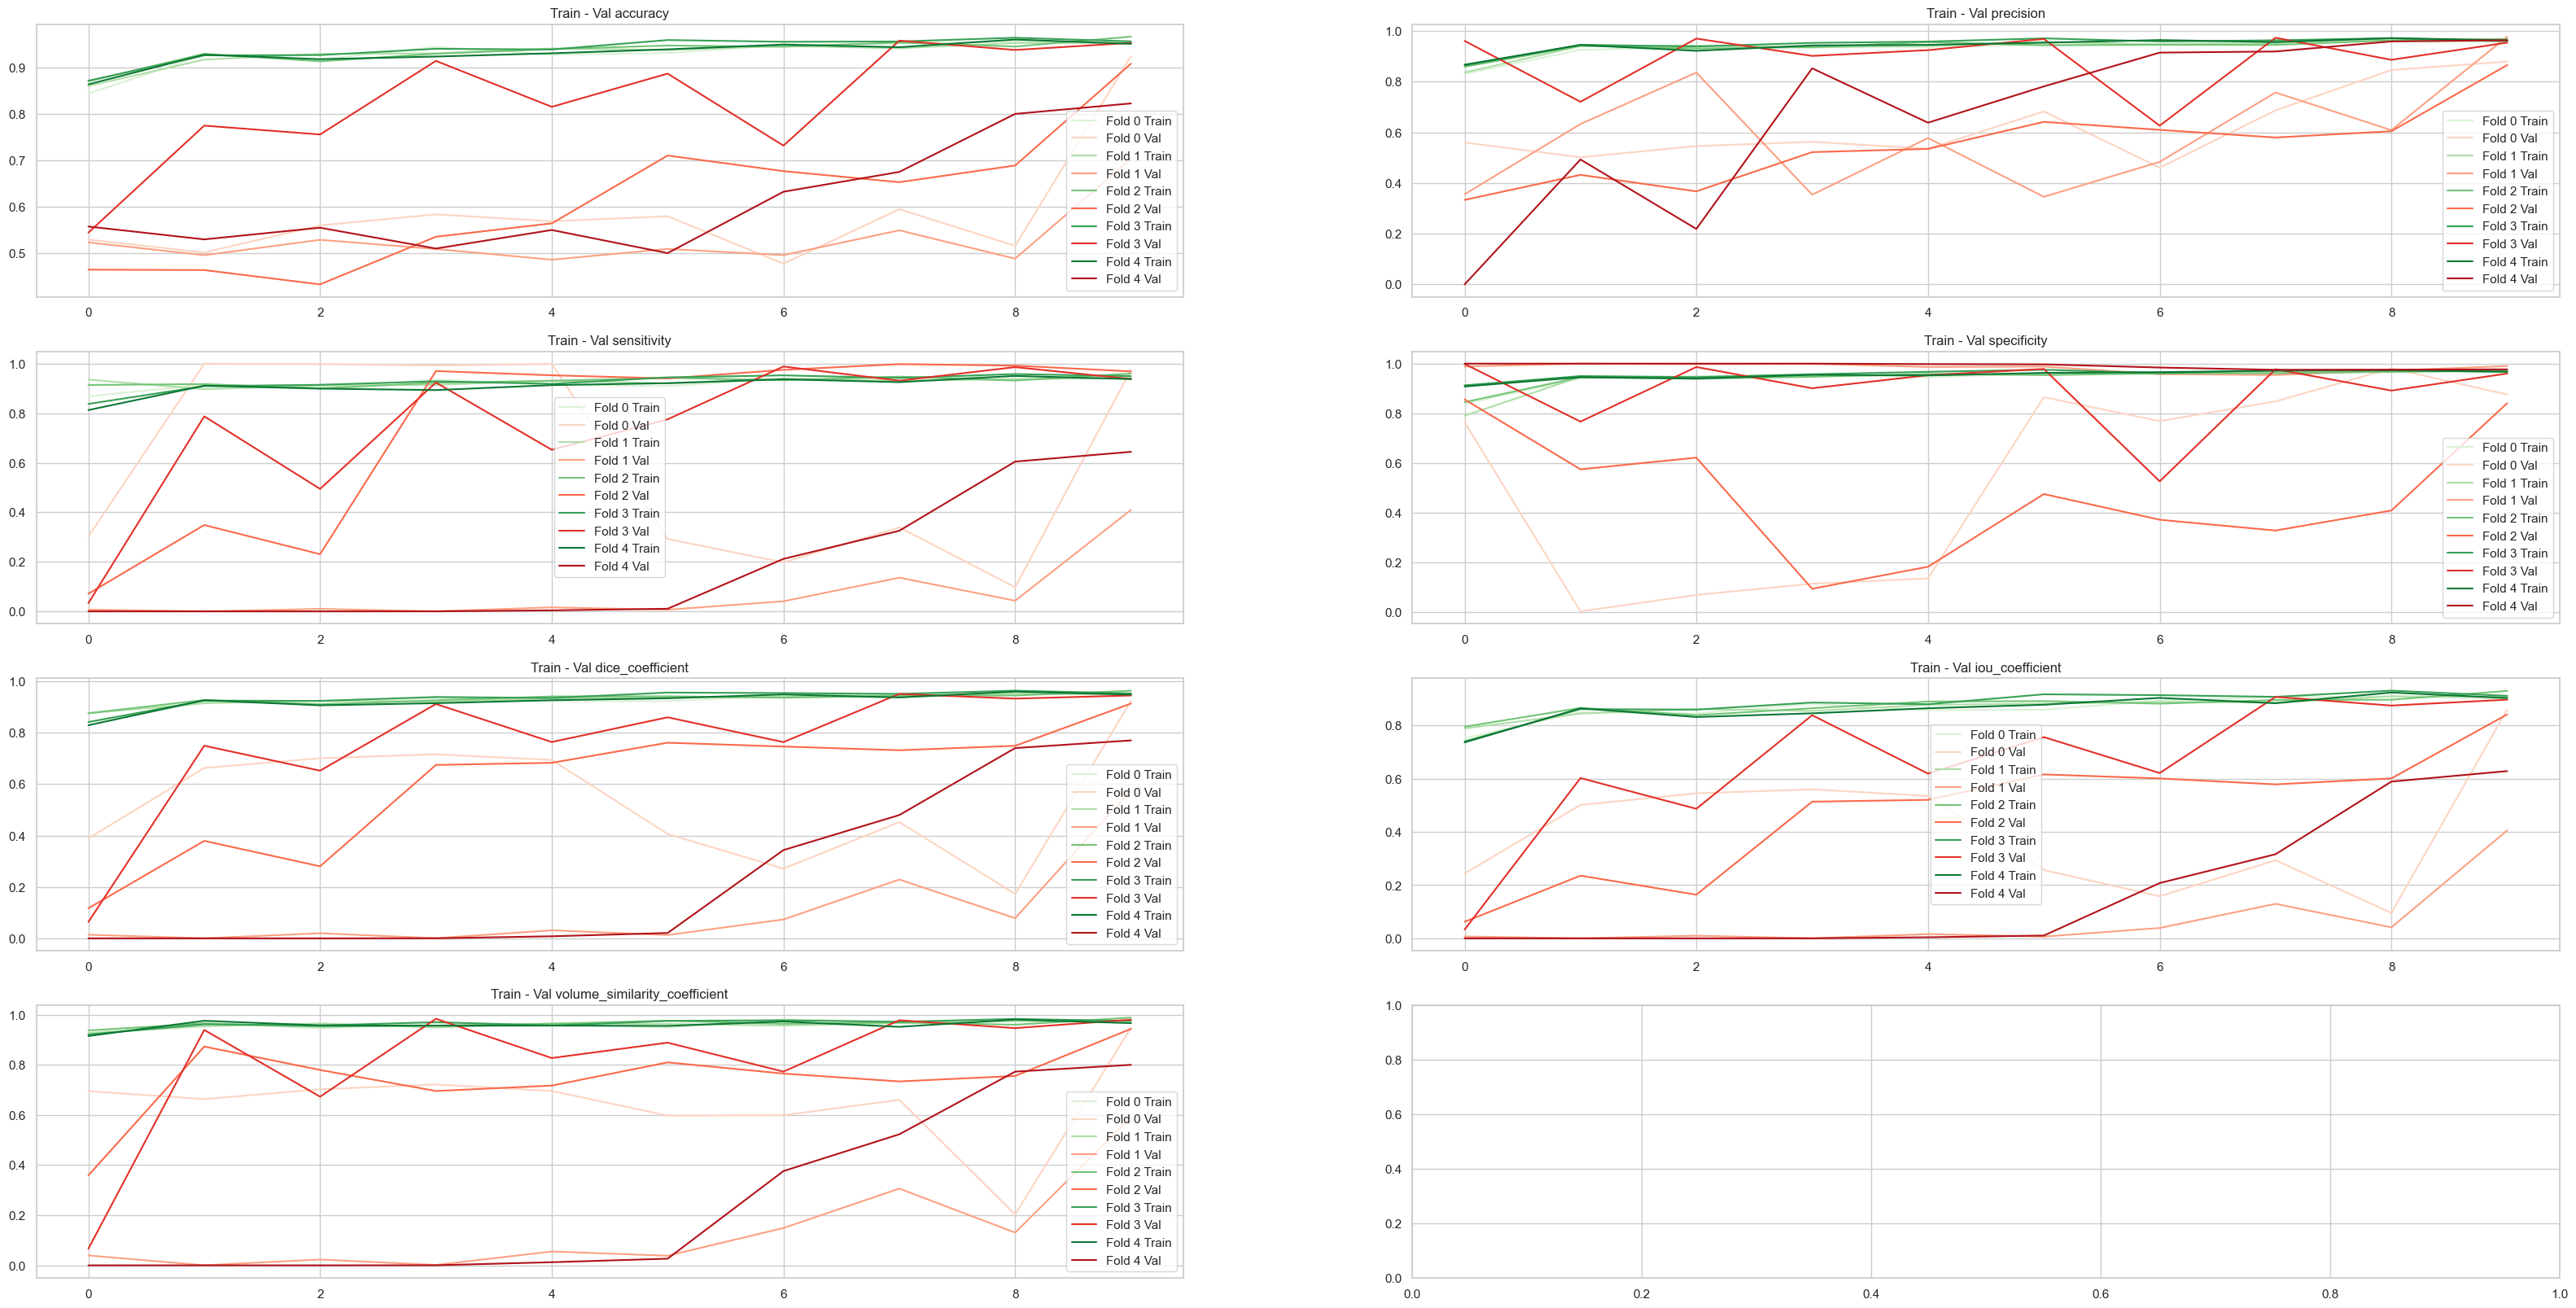

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axs = plt.subplots(4, 2, figsize=(40, 20))
axs = axs.ravel()

# Define palettes
train_palette = sns.color_palette("Greens", n_colors=config['k'])
val_palette = sns.color_palette("Reds", n_colors=config['k'])

# For each metric subplot, plot the history of each fold
for i, key in enumerate(metrics_dic.keys()):
    axs[i].set_title('Train - Val ' + key)
    for j in range(config['k']):
        axs[i].plot(np.array(history_k[j][key]), color=train_palette[j], label=f'Fold {j} Train')
        axs[i].plot(np.array(history_k[j]['val_'+key]), color=val_palette[j], label=f'Fold {j} Val')
    # Legend with fold number
    axs[i].legend()

plt.savefig('../results/'+config['model_name']+'/k_train_val_metrics.png')
plt.show()

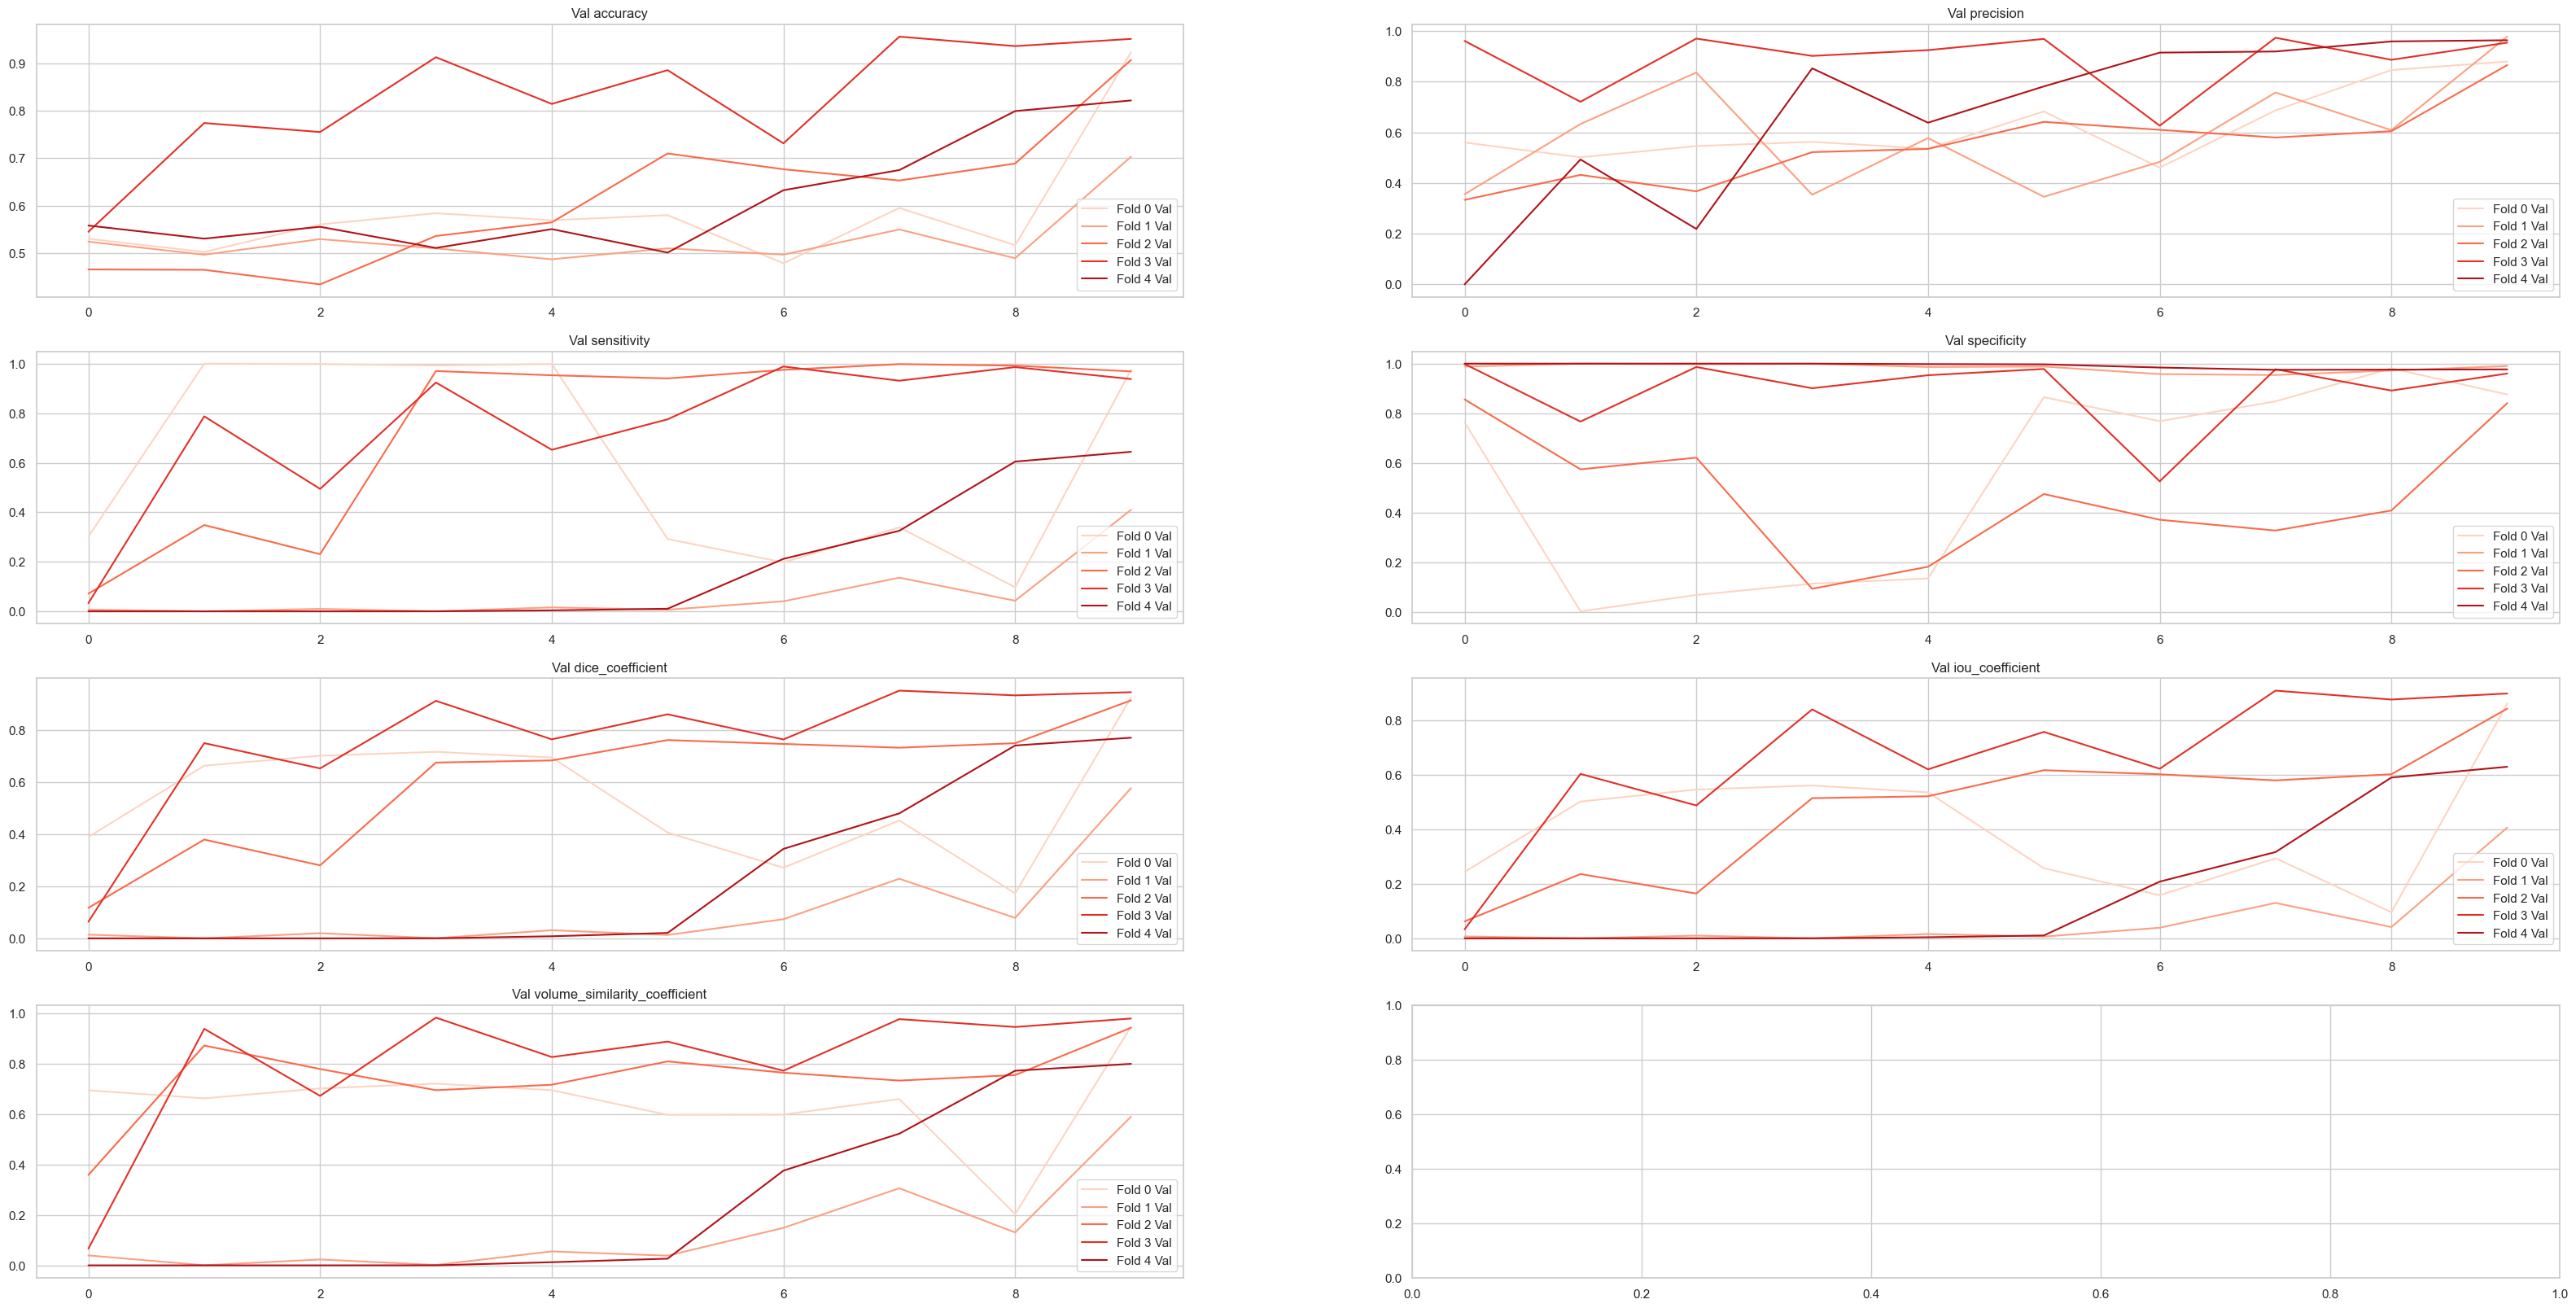

In [ ]:
#plot the val metrics
sns.set(style="whitegrid")
fig, axs = plt.subplots( 4, 2, figsize=(40, 20))
val_palette = sns.color_palette("Reds", n_colors=config['k'])
axs = axs.ravel()
# for each metric subplot, plot the history of each fold
for i, key in enumerate(metrics_dic.keys()):
    axs[i].set_title('Val ' + key)
    for j in range(config['k']):
        axs[i].plot(np.array(history_k[j]['val_'+key]), color=val_palette[j])
        # legend with fold number
        axs[i].legend([f'Fold {i} Val' for i in range(config['k'])], loc='lower right')

plt.savefig('../results/'+config['model_name']+'/k_val_metrics.png')
plt.show()

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




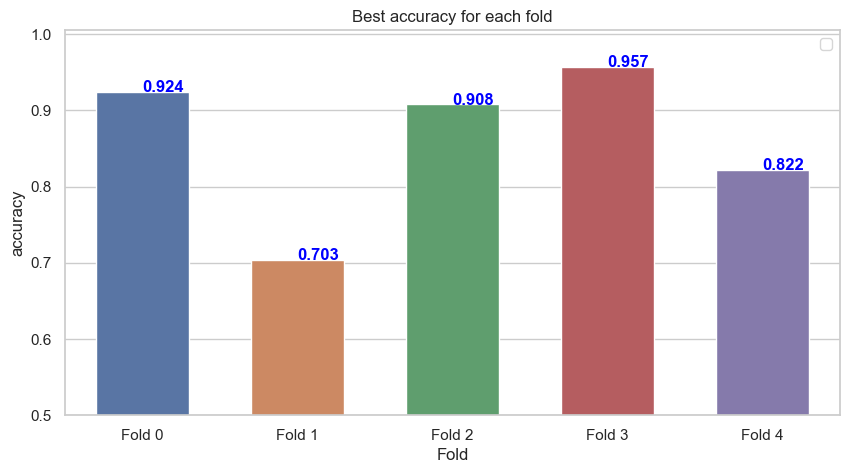

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




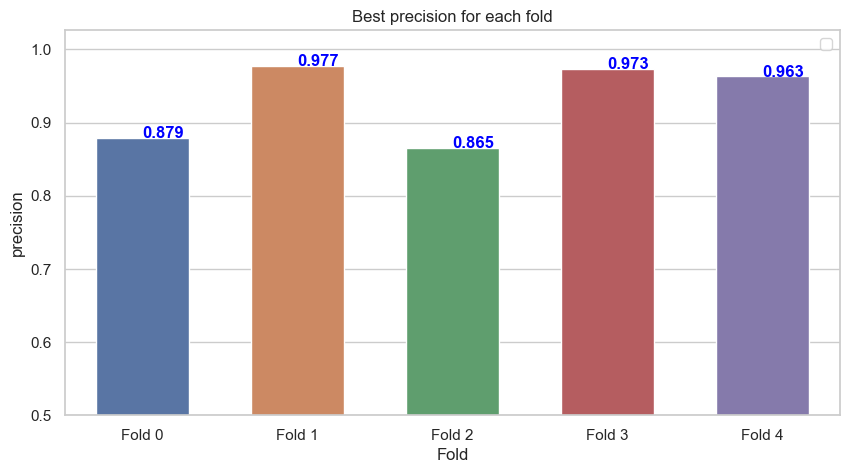

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




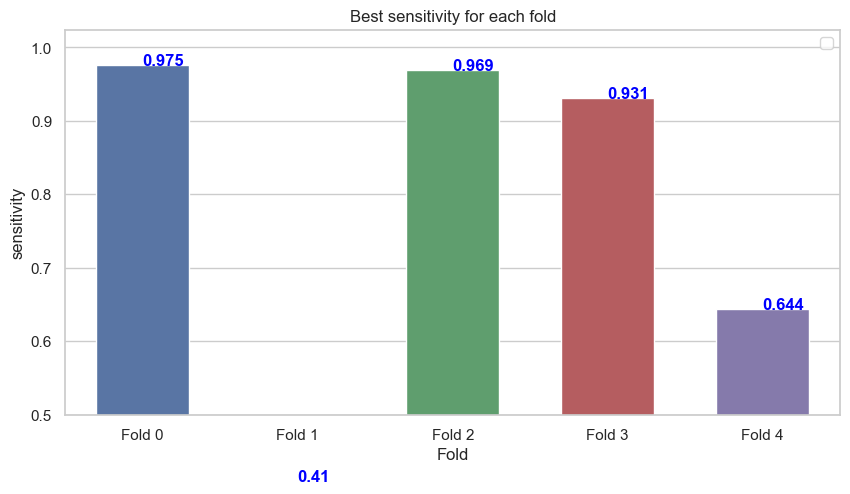

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




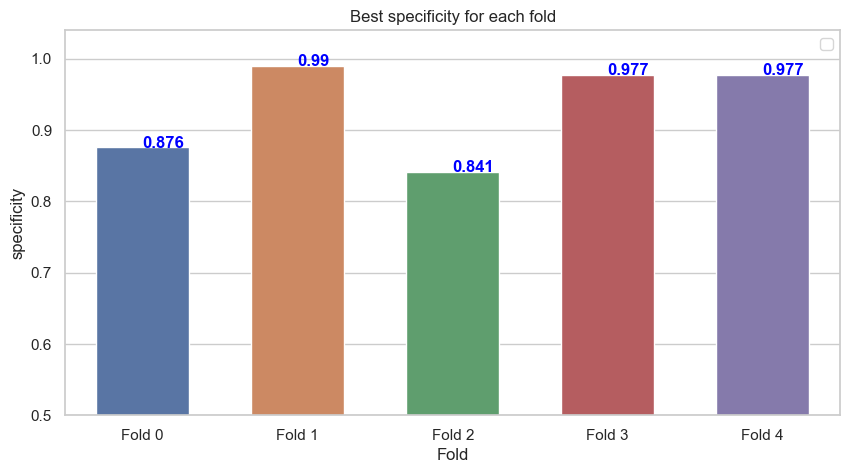

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




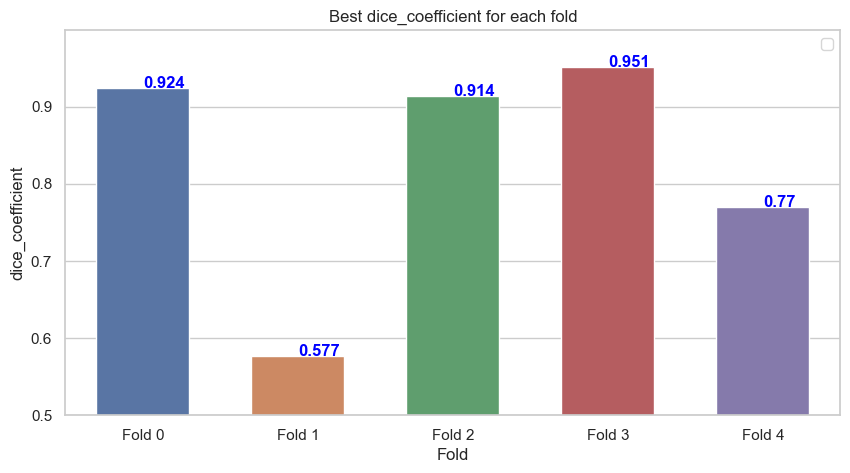

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




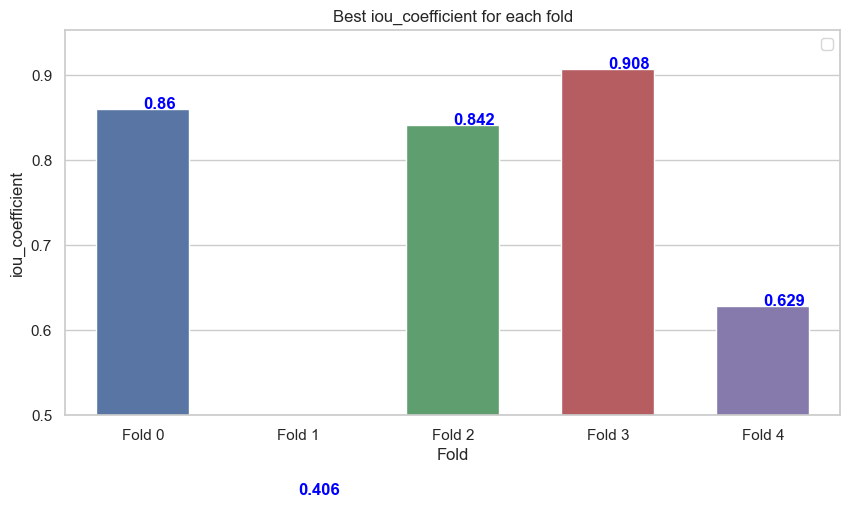

C:\Users\fmoro\AppData\Local\Temp\ipykernel_12964\226105884.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




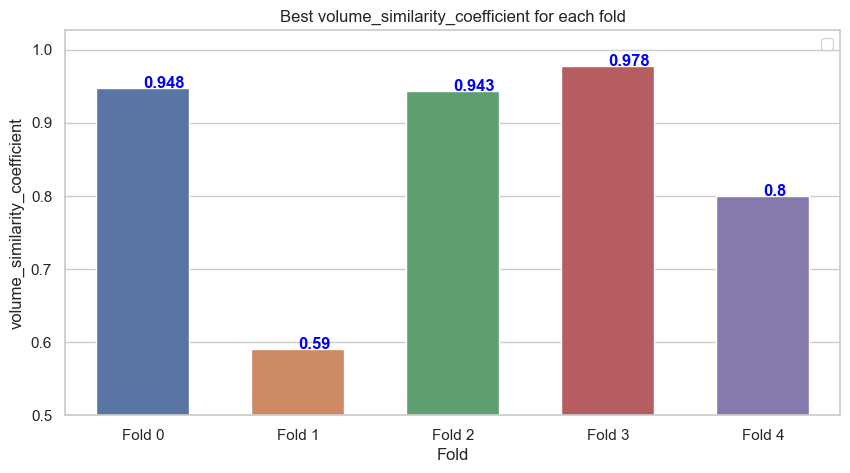

In [ ]:
for key in metrics_dic.keys():

    # bar plot with seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[f'Fold {i}' for i in range(config['k'])], y=[h['val_'+key] for h in best_metrics_val], palette="deep", width=0.6)
    plt.xlabel('Fold')

    plt.legend()
    
    # Set y-axis limits starting from 0.5
    plt.ylim(bottom=0.5)

    plt.ylabel(key)
    plt.title('Best '+key+' for each fold')
    # add exact value
    for i, v in enumerate([h['val_'+key] for h in best_metrics_val]):
        plt.text(i, v, str(round(v, 3)), color='blue', fontweight='bold')
    
    plt.savefig('../results/'+config['model_name']+'/best_val_'+key+'.png')
    plt.show()

In [ ]:
# save conf in a file
with open('../results/'+config['model_name']+'/config.txt', 'w') as f:
    for key, value in config.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
import tabulate
# Convert the list of dictionaries to a pandas dataframe by adding the fold number as a column
all_fold_metrics_df = pd.concat(all_fold_metrics, axis=0)
all_fold_metrics_df['Fold'] = np.concatenate([[i]*len(all_fold_metrics[i]) for i in range(config['k'])])
# Save the dataframe to an excel file

print(tabulate.tabulate(all_fold_metrics_df, headers='keys', tablefmt='pretty'))

all_fold_metrics_df.to_excel('../results/'+config['model_name']+'/all_fold_metrics.xlsx', index=False)

+----+---------------------+-------------------------------+--------+----------+---------------------+---------------------+------+
|    |       Subject       |            Metric             | Stride | Modality |      Class: 0       |        Mean         | Fold |
+----+---------------------+-------------------------------+--------+----------+---------------------+---------------------+------+
| 0  | TBI_MC_fp_22_128_5W |       dice_coefficient        |   48   |  FLASH   | 0.9660443663597107  | 0.9660443663597107  |  0   |
| 1  | TBI_MC_fp_22_128_5W |       dice_coefficient        |   64   |  FLASH   | 0.9685002565383911  | 0.9685002565383911  |  0   |
| 2  | TBI_MC_fp_22_133_5M |       dice_coefficient        |   64   |  FLASH   | 0.9394558668136597  | 0.9394558668136597  |  0   |
| 3  | TBI_MC_fp_22_133_5M |       dice_coefficient        |   48   |  FLASH   | 0.9375796318054199  | 0.9375796318054199  |  0   |
| 4  | TBI_MC_fp_22_135_5M |       dice_coefficient        |   64   |  FLASH

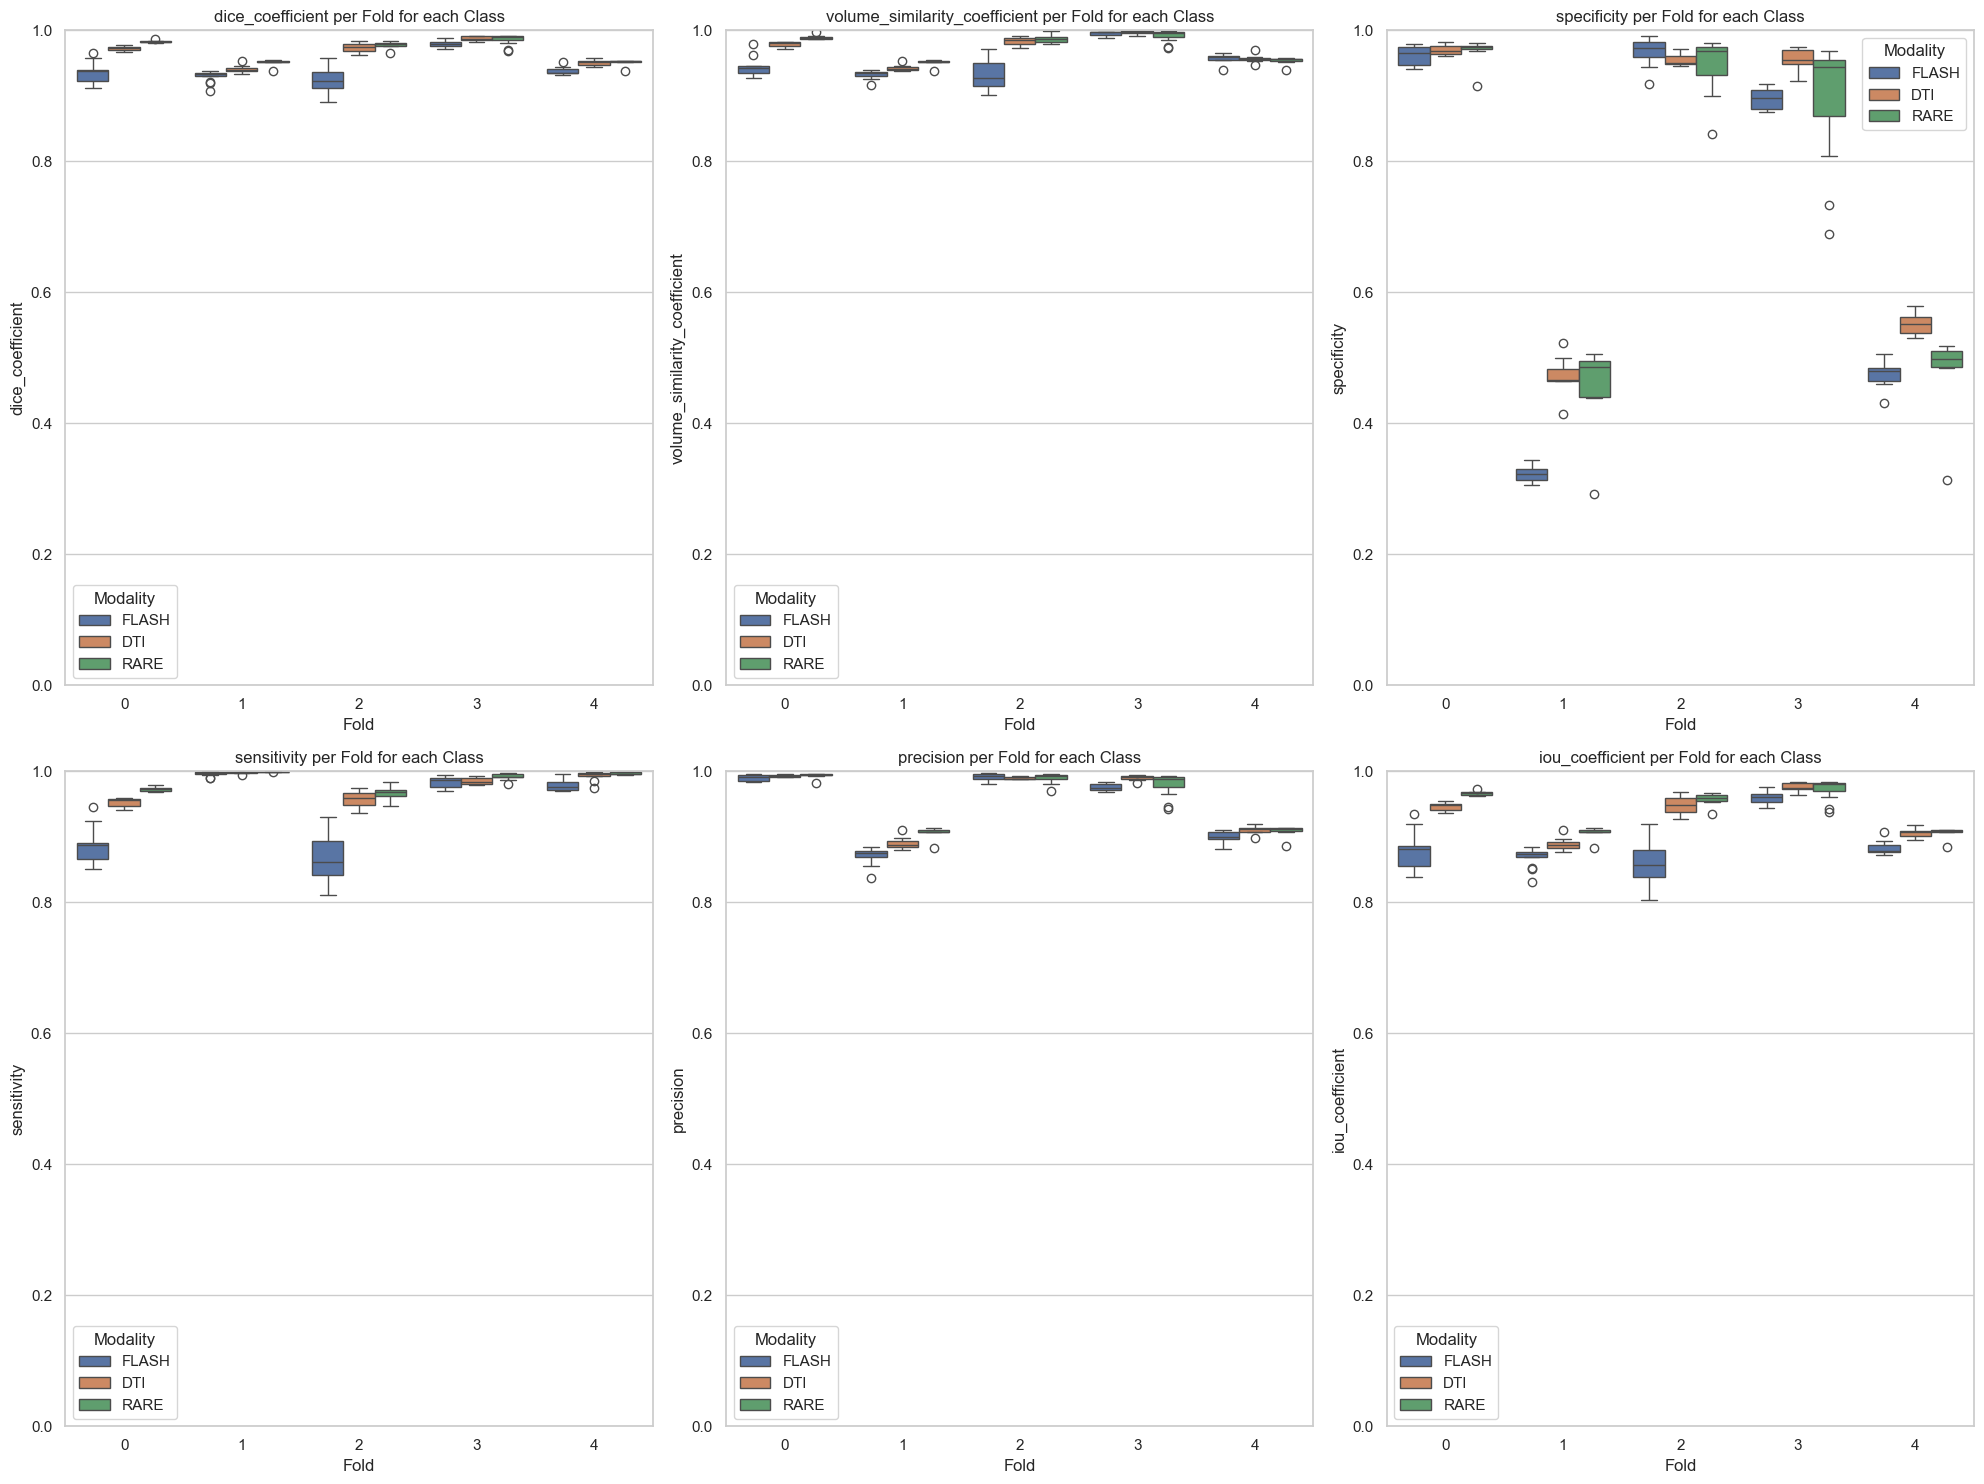

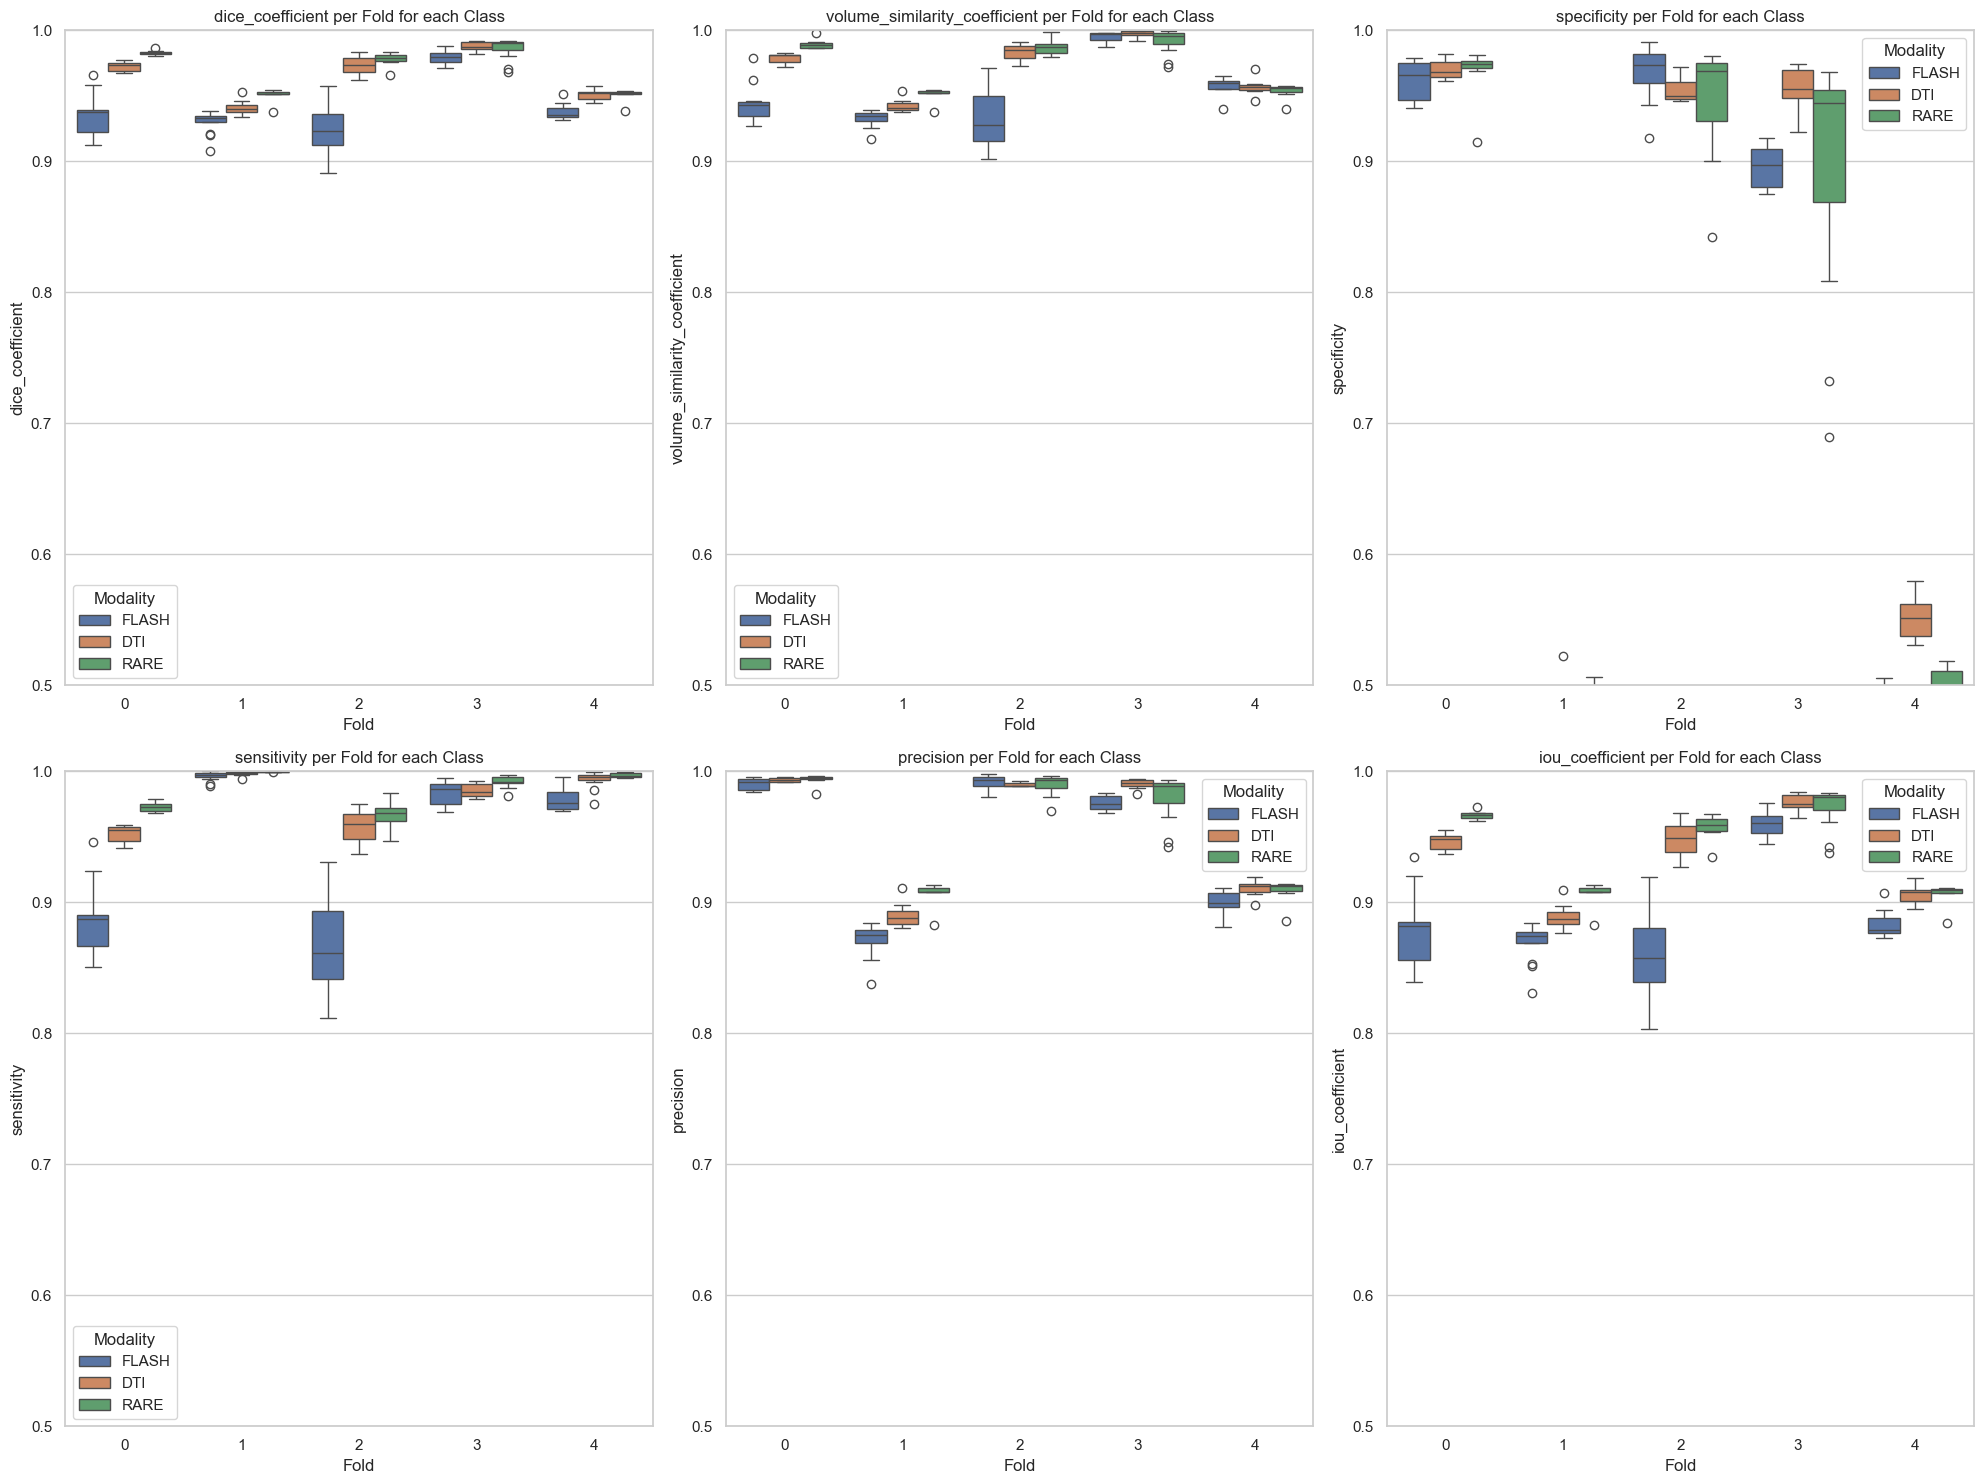

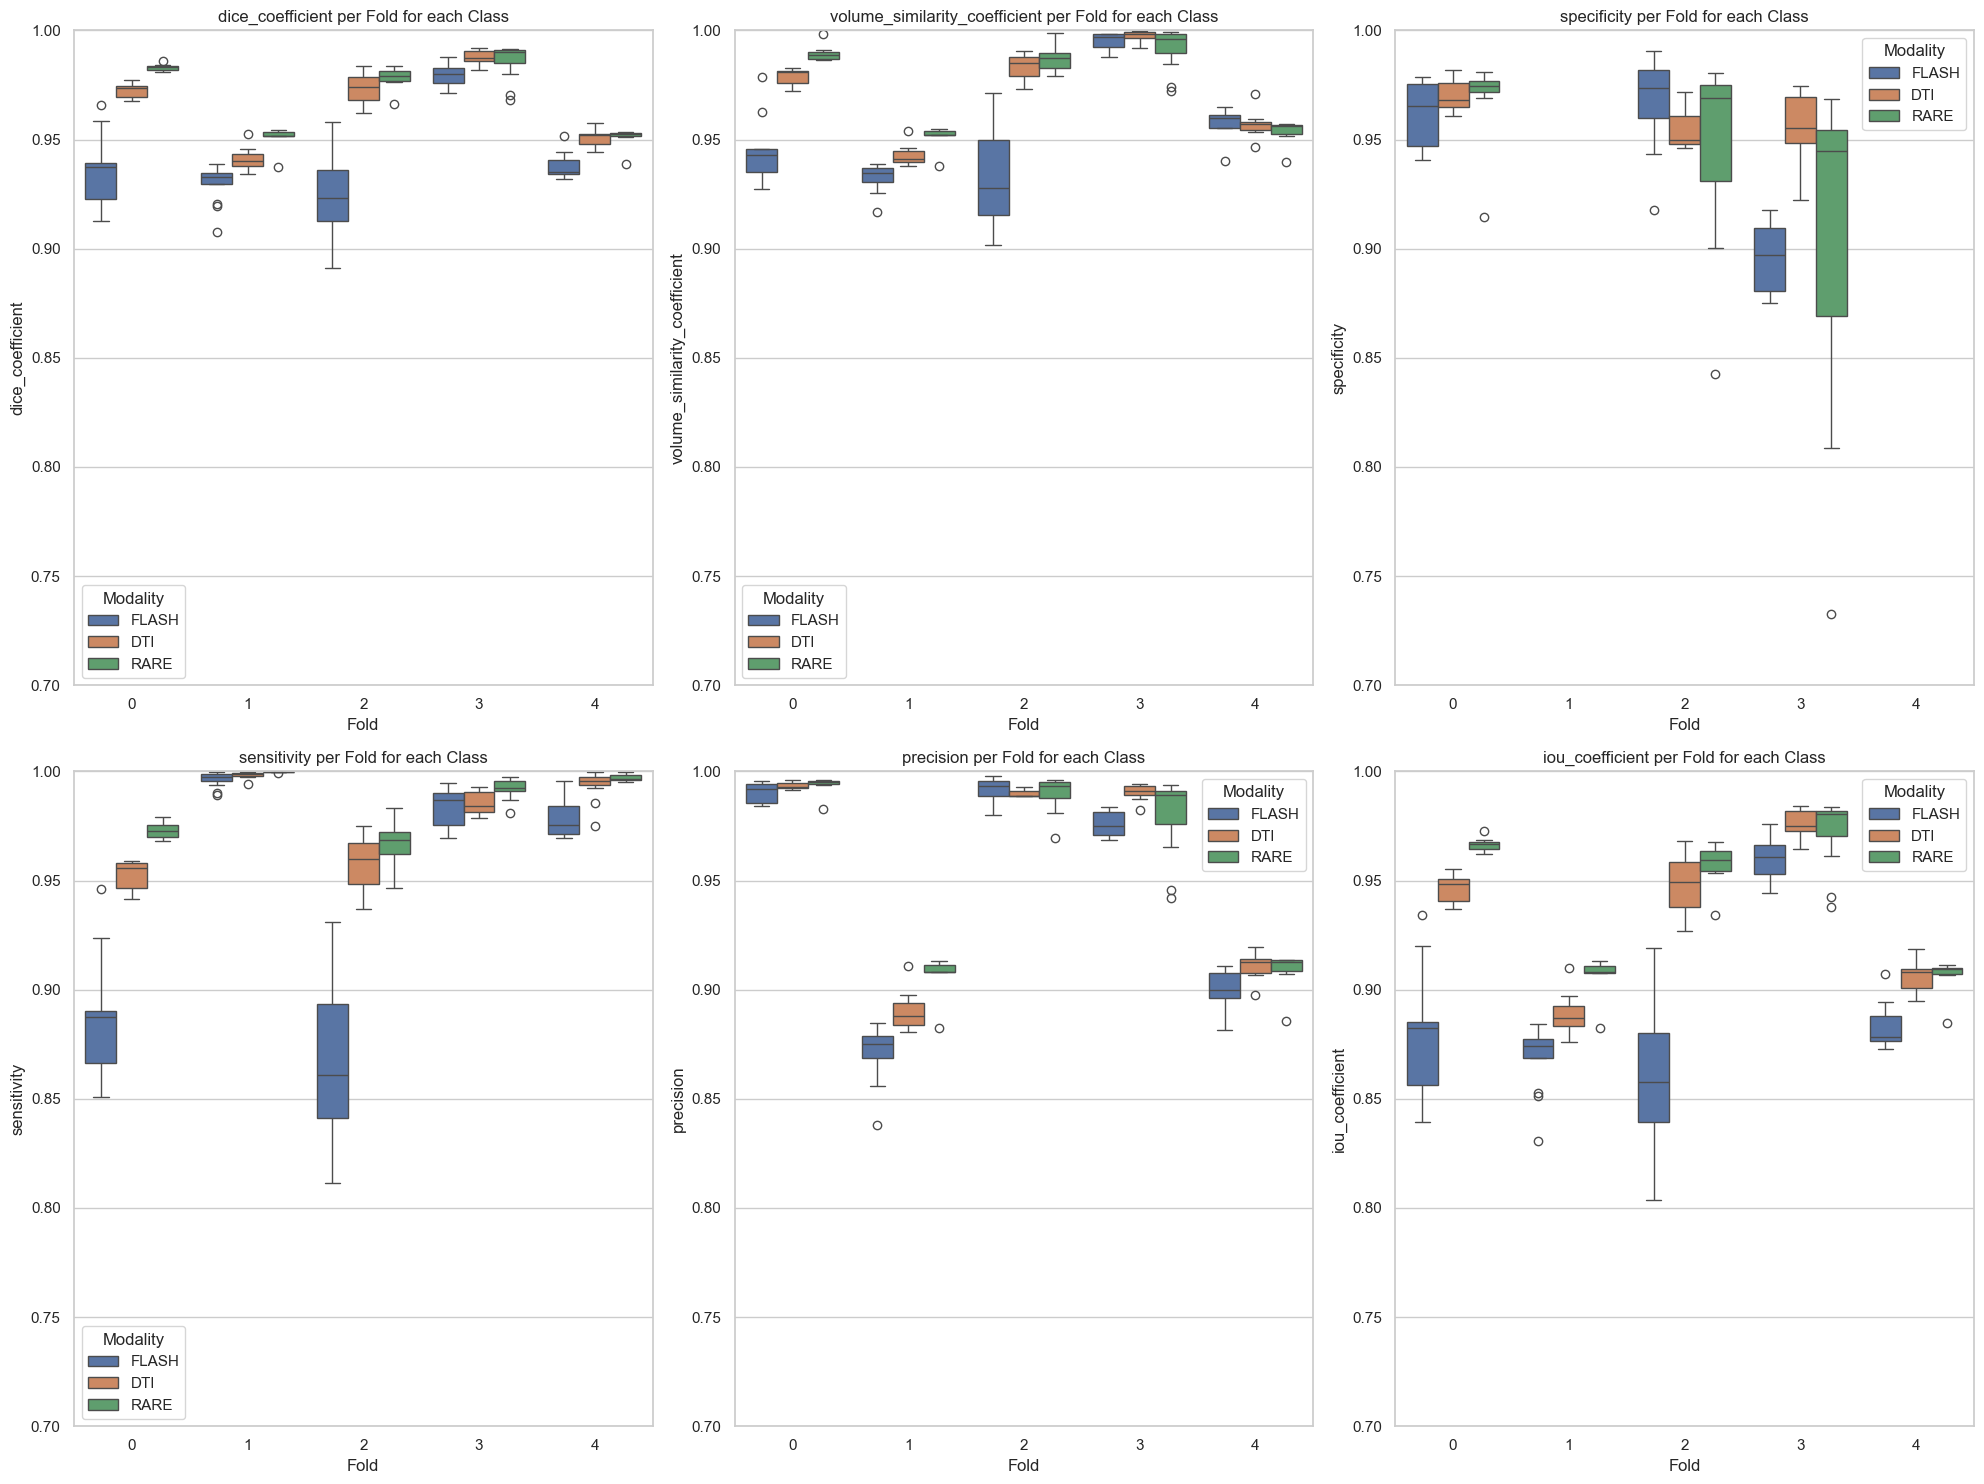

In [ ]:
def plot_fold_comparisons(metric, stride, all_fold_metrics_df, ax, low_limit=0):
    # Extract the 'Mean' column of each metric for each fold associated with the lower stride for 'dice_coeff'
    fold_metrics = all_fold_metrics_df[all_fold_metrics_df['Metric'] == metric]
    fold_metrics = fold_metrics[fold_metrics['Stride'] == stride]

    # Make 'Subject' a column and not an index
    fold_metrics = fold_metrics.reset_index()

    # Reset the index
    # print(tabulate.tabulate(fold_metrics, headers='keys', tablefmt='pretty'))
    melted_df = pd.melt(fold_metrics, id_vars=['Subject', 'Fold', 'Modality', 'Metric'], value_vars=['Mean'], var_name='Class', value_name='Means')


    # Plot the comparison between the folds for each class
    sns.boxplot(x='Fold', y='Means', hue='Modality', data=melted_df, ax=ax, palette='deep')

    ax.set_title(f'{metric} per Fold for each Class')
    ax.set_xlabel('Fold')
    ax.set_ylabel(metric)

    # Limit the y-axis to 0 to 1
    ax.set_ylim(low_limit, 1)

# Extract unique metrics column values
metrics = all_fold_metrics_df['Metric'].unique()
strides = all_fold_metrics_df['Stride'].unique()
_min_stride = np.min(strides)

# Create a figure with a subplot for each metric in a grid
_n_col = 3
_n_row = len(metrics) // _n_col


fig, axs = plt.subplots(_n_row, _n_col, figsize=(20, 15))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    plot_fold_comparisons(metric, _min_stride, all_fold_metrics_df, axs[i], low_limit=0)

plt.tight_layout()
plt.savefig('../results/'+config['model_name']+'/fold_comparison_metrics_0_1.png')
plt.show()


fig, axs = plt.subplots(_n_row, _n_col, figsize=(20, 15))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    plot_fold_comparisons(metric, _min_stride, all_fold_metrics_df, axs[i], low_limit=0.5)

plt.tight_layout()
plt.savefig('../results/'+config['model_name']+'/fold_comparison_metrics_05_1.png')
plt.show()

fig, axs = plt.subplots(_n_row, _n_col, figsize=(20, 15))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    plot_fold_comparisons(metric, _min_stride, all_fold_metrics_df, axs[i], low_limit=0.7)

plt.tight_layout()
plt.savefig('../results/'+config['model_name']+'/fold_comparison_metrics_07_1.png')
plt.show()